<h2>BODS real time position</h2>

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime, timedelta
import time
import os
from bods_client.client import BODSClient
from bods_client.models import BoundingBox, GTFSRTParams, SIRIVMParams, Siri
import matplotlib.pyplot as plt

20
PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,POPDEN,HHOLDS,AVHHOLDSZ,IMD_score,Index_of_M,Index_of_1,Index_of_2,Index_of_3,Index_of_4,geometry
0,E01000850,Camden 026A,E02000191,Camden 026,E09000007,Camden,E12000007,London,1694,1281,...,86.7,664,1.9,19686,970,Camden 026A,E09000007,Camden,19686,"POLYGON ((-0.13123 51.52343, -0.12924 51.52175..."
1,E01000851,Camden 026B,E02000191,Camden 026,E09000007,Camden,E12000007,London,2383,1645,...,178.5,861,1.9,18953,971,Camden 026B,E09000007,Camden,18953,"POLYGON ((-0.14081 51.52439, -0.13993 51.52407..."
2,E01000854,Camden 026D,E02000191,Camden 026,E09000007,Camden,E12000007,London,1833,1643,...,97.1,718,2.3,18104,974,Camden 026D,E09000007,Camden,18104,"POLYGON ((-0.13225 51.52493, -0.13206 51.52474..."
3,E01000855,Camden 028A,E02000193,Camden 028,E09000007,Camden,E12000007,London,1764,1714,...,55.0,1111,1.5,19276,975,Camden 028A,E09000007,Camden,19276,"POLYGON ((-0.13097 51.52499, -0.12978 51.52390..."
4,E01000919,Camden 028D,E02000193,Camden 028,E09000007,Camden,E12000007,London,2014,1658,...,131.8,834,2.0,12962,909,Camden 028D,E09000007,Camden,12962,"POLYGON ((-0.12700 51.51795, -0.12624 51.51700..."


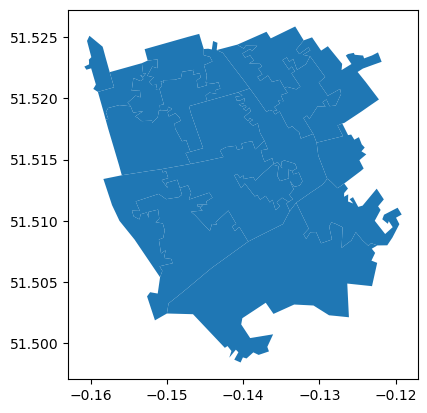

In [2]:
# load the shapefile generated from QGIS
shp_path = 'D:/KCL sm2/individual_project/data/layers_export/regent_street_big.shp'
regent_gdf = gpd.read_file(shp_path)
print(len(regent_gdf))

# set the crs to the same as the open street map
print(regent_gdf.crs)
regent_gdf = regent_gdf.to_crs(epsg=4326)
regent_gdf.plot()

regent_gdf.head()

In [3]:
# BODS API
API_KEY = '44ba2b2684426b09be49aecb32e5da1bcb821add'
client = BODSClient(api_key=API_KEY)

minx, miny, maxx, maxy = regent_gdf.total_bounds

# bounding box
bounding_box = BoundingBox(
    min_latitude=miny - 0.1,
    max_latitude=maxy + 0.1,
    min_longitude=minx - 0.1,
    max_longitude=maxx + 0.1,
)

# save the file
SAVE_PATH = r"D:\KCL sm2\individual_project\data\BODS_position"
os.makedirs(SAVE_PATH, exist_ok=True)

In [4]:
# get real time bus positions and transform to dataframe
def get_bus_positions(client, bounding_box):
    gtfs_rt_params = GTFSRTParams(bounding_box=bounding_box)
    gtfs_rt_data = client.get_gtfs_rt_data_feed(params=gtfs_rt_params)
    
    bus_positions = []
    for entity in gtfs_rt_data.entity:
        if entity.HasField('vehicle'):
            vehicle = entity.vehicle
            position = vehicle.position
            bus_positions.append({
                'id': entity.id,
                'lat': position.latitude,
                'lon': position.longitude,
                'vehicle_id': vehicle.vehicle.id,
                'vehicle_label': vehicle.vehicle.label,
                'timestamp': datetime.fromtimestamp(vehicle.timestamp)
            })
    
    return pd.DataFrame(bus_positions)

In [5]:
# filter the buses in regent street
def filter_buses_in_regent(api_dataframe, regent_gdf):
    geometry = [Point(xy) for xy in zip(api_dataframe.lon, api_dataframe.lat)]
    gdf = gpd.GeoDataFrame(api_dataframe, geometry=geometry)
    
    in_regent = gdf.within(regent_gdf.unary_union)
    filtered_df = gdf[in_regent].copy().reset_index(drop=True)
    
    return filtered_df[['id', 'lat', 'lon', 'vehicle_id', 'vehicle_label', 'timestamp']]

In [6]:
# update the 20 minutes dataframe with the location after 20 minutes
def update_20min_dataframe(current_api_df, regent_gdf, timestamp):
    filtered_df = filter_buses_in_regent(current_api_df, regent_gdf)
    
    new_20min_df = filtered_df.copy()
    new_20min_df['timestamp'] = timestamp
    new_20min_df['20min_lat'] = None
    new_20min_df['20min_lon'] = None
    
    return new_20min_df

In [7]:
# update the 20 minutes dataframe with the location after 20 minutes
def fill_previous_20min_dataframe(prev_20min_df, current_api_df):
    """fill 20min_lat and 20min_lon columns in prev_20min_df with the current location"""
    for index, row in prev_20min_df.iterrows():
        if row['vehicle_id'] in current_api_df['vehicle_id'].values:
            current_bus = current_api_df[current_api_df['vehicle_id'] == row['vehicle_id']].iloc[0]
            prev_20min_df.at[index, '20min_lat'] = current_bus['lat']
            prev_20min_df.at[index, '20min_lon'] = current_bus['lon']
    
    return prev_20min_df

In [8]:
# save the dataframes
def save_dataframes(api_df, min20_df, timestamp):
    # both dataframes are saved with the same timestamp
    timestamp_str = timestamp.strftime('%Y%m%d_%H%M%S')
    
    if api_df is not None:
        api_filename = f"api_dataframe_{timestamp_str}.csv"
        api_filepath = os.path.join(SAVE_PATH, api_filename)
        api_df.to_csv(api_filepath, index=False)
        print(f"Saved {api_filename}")
    
    if min20_df is not None:
        min20_filename = f"20min_dataframe_{timestamp_str}.csv"
        min20_filepath = os.path.join(SAVE_PATH, min20_filename)
        min20_df.to_csv(min20_filepath, index=False)
        print(f"Saved {min20_filename}")
    
    if api_df is None and min20_df is None:
        print(f"No data to save for timestamp {timestamp_str}")

In [9]:
# call the API every 20 minutes
def wait_until(target_time):
    current_time = datetime.now()
    if current_time < target_time:
        time_to_wait = (target_time - current_time).total_seconds()
        print(f"Waiting for {time_to_wait:.2f} seconds until {target_time}")
        time.sleep(time_to_wait)

In [10]:
# run the analysis
def run_analysis(start_time, end_time, interval):
    if start_time == 'now':
        start_time = datetime.now().replace(microsecond=0, second=0)
        start_time += timedelta(minutes=interval.seconds // 60 - start_time.minute % (interval.seconds // 60))
    
    current_time = start_time
    prev_20min_df = None
    prev_timestamp = None
    
    while current_time <= end_time:
        print(f"Preparing to fetch data for {current_time}")
        
        wait_until(current_time)
        
        try:
            # get the current time as the timestamp
            actual_time = datetime.now()
            
            # get current bus positions
            api_dataframe = get_bus_positions(client, bounding_box)
            
            # add new columns
            current_20min_df = update_20min_dataframe(api_dataframe, regent_gdf, actual_time)

            # print the number of buses
            print(f"Time point: {actual_time}, Total number of buses: {len(api_dataframe)}, Number of buses within Regent area: {len(current_20min_df)}")
            
            # if there is a previous 20 minutes dataframe, fill the 20min_lat and 20min_lon columns
            if prev_20min_df is not None:
                filled_prev_20min_df = fill_previous_20min_dataframe(prev_20min_df, api_dataframe)
                # save filled previous 20 minutes dataframe
                save_dataframes(None, filled_prev_20min_df, prev_timestamp)
            
            # save the current API dataframe and 20 minutes dataframe
            save_dataframes(api_dataframe, current_20min_df, actual_time)
            
            # update prev_20min_df and prev_timestamp for the next iteration
            prev_20min_df = current_20min_df
            prev_timestamp = actual_time
        
        except Exception as e:
            print(f"Error occurred: {e}")
        
        current_time += interval
    
    print("Analysis complete.")

In [11]:
# set the start time, end time and interval
start_time = datetime(2024, 7, 25, 9, 0)  # year, month, day, hour, minute
end_time = start_time + timedelta(hours=14)  # the analysis will run for 14 hours
interval = timedelta(minutes=20)  # every 20 minutes

run_analysis(start_time, end_time, interval)

Preparing to fetch data for 2024-07-25 09:00:00
Waiting for 9264.70 seconds until 2024-07-25 09:00:00
Time point: 2024-07-25 09:00:00.007474, Total number of buses: 3884, Number of buses within Regent area: 153
Saved api_dataframe_20240725_090000.csv
Saved 20min_dataframe_20240725_090000.csv
Preparing to fetch data for 2024-07-25 09:20:00
Waiting for 1196.98 seconds until 2024-07-25 09:20:00
Time point: 2024-07-25 09:20:00.008311, Total number of buses: 3870, Number of buses within Regent area: 148
Saved 20min_dataframe_20240725_090000.csv
Saved api_dataframe_20240725_092000.csv
Saved 20min_dataframe_20240725_092000.csv
Preparing to fetch data for 2024-07-25 09:40:00
Waiting for 1196.39 seconds until 2024-07-25 09:40:00
Time point: 2024-07-25 09:40:00.007124, Total number of buses: 3864, Number of buses within Regent area: 168
Saved 20min_dataframe_20240725_092000.csv
Saved api_dataframe_20240725_094000.csv
Saved 20min_dataframe_20240725_094000.csv
Preparing to fetch data for 2024-07-2